## Imports & Settings

In [1]:
import os
os.chdir('..')
# os.getcwd( )

In [2]:
from utils import *

import re
import nltk
import string
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import datasets
from datasets import load_dataset, load_metric, Dataset

## Load Dataset

In [3]:
dataset = load_dataset("cosmos_qa")

Found cached dataset cosmos_qa (/Users/jarradjinx/.cache/huggingface/datasets/cosmos_qa/default/0.1.0/3e18538cbfdb2c04189b16642715f0f6da3e97ed5df0aadcec3641245b2cf157)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
# save dataset locally as a backup
dataset.save_to_disk("data/inter_CosmosQA/source_cosmosqa.hf")

Saving the dataset (0/1 shards):   0%|          | 0/25262 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/6963 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2985 [00:00<?, ? examples/s]

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'context', 'question', 'answer0', 'answer1', 'answer2', 'answer3', 'label'],
        num_rows: 25262
    })
    test: Dataset({
        features: ['id', 'context', 'question', 'answer0', 'answer1', 'answer2', 'answer3', 'label'],
        num_rows: 6963
    })
    validation: Dataset({
        features: ['id', 'context', 'question', 'answer0', 'answer1', 'answer2', 'answer3', 'label'],
        num_rows: 2985
    })
})

In [6]:
# we will need to view and prep the datasets
# this is more easily done as dataframes
cosmos_train_df = dataset['train'].to_pandas()
cosmos_test_df = dataset['test'].to_pandas() 
cosmos_validate_df = dataset['validation'].to_pandas() 

In [7]:
print(cosmos_train_df['context'][0])
print(cosmos_train_df['question'][0])
print(cosmos_train_df['answer0'][0])
print(cosmos_train_df['answer1'][0])
print(cosmos_train_df['answer2'][0])
print(cosmos_train_df['answer3'][0])
print(cosmos_train_df['label'][0])


Good Old War and person L : I saw both of these bands Wednesday night , and they both blew me away . seriously . Good Old War is acoustic and makes me smile . I really can not help but be happy when I listen to them ; I think it 's the fact that they seemed so happy themselves when they played .
In the future , will this person go to see other bands play ?
None of the above choices .
This person likes music and likes to see the show , they will see other bands play .
This person only likes Good Old War and Person L , no other bands .
Other Bands is not on tour and this person can not see them .
1


## View Dataset

Loading in the datasets, we note that the "test" split provided does not have labels. This dataset is likely for impartial, 3rd party evaluation. As we do not have the true labels, we will not use this dataset. Rather, we will split the training dataset in order to create a holdout test set.

In [8]:
cosmos_train_df.head()

,id,context,question,answer0,answer1,answer2,answer3,label
0,3Q9SPIIRWJKVQ8244310E8TUS6YWAC##34V1S5K3GTZMDU...,Good Old War and person L : I saw both of thes...,"In the future , will this person go to see oth...",None of the above choices .,This person likes music and likes to see the s...,This person only likes Good Old War and Person...,Other Bands is not on tour and this person can...,1
1,3E24UO25QZOMYXHZN4TEH9EMT9GO6L##3UN61F00HXNWYQ...,I mean it : not one person said ANYTHING to me...,Why might have the temp agency tell me I am no...,The company hiring the temp workers might have...,The temp agency hiring the temp workers might ...,None of the above choices .,I might have had a change of mind working for ...,0
2,3M4KL7H8KVL125AYH2V35D1E0A016T##3SB5N7Y3O426ET...,Leaving my shift Thursday day shift I arrived ...,What may have caused the radio to erupt with d...,My partner needed a medic unit .,Someone was running from the ambulances after ...,None of the above choices .,Someone was running from the cops and got into...,3
3,3D5G8J4N5CI2K40F4RZLF9OG2L4VTJ##34MAJL3QP721EU...,"So , last day in Seattle , and my flight was a...",Why did I chit chat with my old manager ?,Because my flight was at 1:30 .,Because I left Seattle feeling really good and...,Because it 's my last day in Seattle .,Because I enjoy talking to him .,3
4,3MQKOF1EE428I44N8B42W7P86DKDW4##3NJM2BJS4ZLBGN...,Ms. Mumma informed Mr. Dail that evidence had ...,Why did I burst into tears ?,Because Ms. Mumma was informative .,Because I had an intense emotional response to...,Because Mr. Dail was informed .,Because I fell out of my chair .,1


In [9]:
cosmos_validate_df.head()

,id,context,question,answer0,answer1,answer2,answer3,label
0,3BFF0DJK8XA7YNK4QYIGCOG1A95STE##3180JW2OT5AF02...,Do i need to go for a legal divorce ? I wanted...,Why is this person asking about divorce ?,If he gets married in the church he wo nt have...,He wants to get married to a different person .,He wants to know if he does nt like this girl ...,None of the above choices .,1
1,3BFF0DJK8XA7YNK4QYIGCOG1A95STE##3180JW2OT5AF02...,Do i need to go for a legal divorce ? I wanted...,Why is he worried about getting married ?,He was married before and she might come back ...,He wants the girl he is going to marry get in ...,He knows that he will be committing polygamy .,None of the above choices .,0
2,3AXFSPQOYQW4GFJD8K4D3JADN54FJ9##352YTHGROWB1DD...,"I was walking home from the store , when I saw...",What may happen after the young man makes his ...,An ambulance would likely come to the scene,The taxi would pick up the young man,None of the above choices .,The bus would arrive at the stop soon,0
3,3AXFSPQOYQW4GFJD8K4D3JADN54FJ9##352YTHGROWB1DD...,"I was walking home from the store , when I saw...",What may happen after the young man makes his ...,None of the above choices .,The bus would arrive at the stop soon,The taxi would pick up the young man,Medical personnel would come to help the old man,3
4,3AXFSPQOYQW4GFJD8K4D3JADN54FJ9##352YTHGROWB1DD...,"I was walking home from the store , when I saw...",What may have happened to the old man ?,He was waiting on a ride,He likely fell on the sidewalk and hit his hea...,He was waiting on the taxi,None of the above choices .,1


Below, we find the test set is for 3rd party evaluation. As we cannot evaluate the results ourselves, we will need to create a test set from the training data. 

In [10]:
cosmos_test_df.head()

,id,context,question,answer0,answer1,answer2,answer3,label
0,3087LXLJ6OUC8YHY6A67DCJPH7Q0FD##31JLPPHS2X95IN...,"HGH and steroid use is rampant in track , and ...",Why is HGH and steroid use rampant in track ?,Because we have to assume that someone is usin...,None of the above choices .,Because any incredible individual achievement ...,Because it 's an American professional sport .,-1
1,3Y40HMYLL3W9O6KZ4BQD8Q730COUXK##3FUI0JHJP0DGWY...,I posted a moment ago regarding a girl i 'd as...,Why do I keep saying that she reiterated that ...,Because I wanted to show off that she wanted me .,I wanted to let people know she loved me .,To let them know that she actually showed inte...,To make sure people knew that she was mine .,-1
2,3VGET1QSZ0XD7646X0PG4HR4RKB7WN##3A4NIXBJ77XJ3Z...,Wait for the red strip in the centre of the cu...,What would happen if one did not apply mascara...,The mascara would not sit properly because the...,It would be difficult to apply mascara afterwa...,It would take longer for the eyelash to proper...,The mascara would mess up the eyelash if appli...,-1
3,302U8RURJZZPV2WONX19ECUGKPHNV5##3NVC2EB65RX2HC...,"And so we bid ... .. And waited , and no one b...",What may have happened our phone batteries wer...,We may have lost the opportunity to buy .,We may have received a letter in the mail inst...,We may have been warned by an auction mediator .,None of the above choices .,-1
4,302U8RURJZZPV2WONX19ECUGKPHNV5##3NVC2EB65RX2HC...,"And so we bid ... .. And waited , and no one b...",Why did we receive a call in wee hour ?,It was too important to wait .,It was a life or death emergency situation .,None of the above choices .,Old people tend to get up too early .,-1


## View Label Distribution
Below we find that the distribution of labels is fairly even.

[Text(0, 0, '6349'),
 Text(0, 0, '6319'),
 Text(0, 0, '6319'),
 Text(0, 0, '6275')]

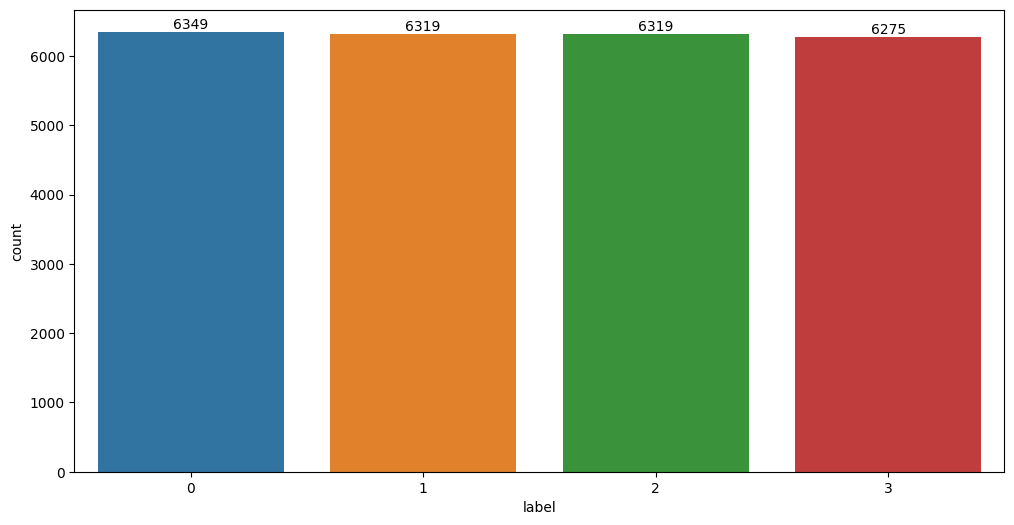

In [11]:
fig = plt.figure(figsize=(12, 6))
ax = sns.countplot(x='label', data=cosmos_train_df)
ax.bar_label(ax.containers[0])

[Text(0, 0, '744'), Text(0, 0, '729'), Text(0, 0, '761'), Text(0, 0, '751')]

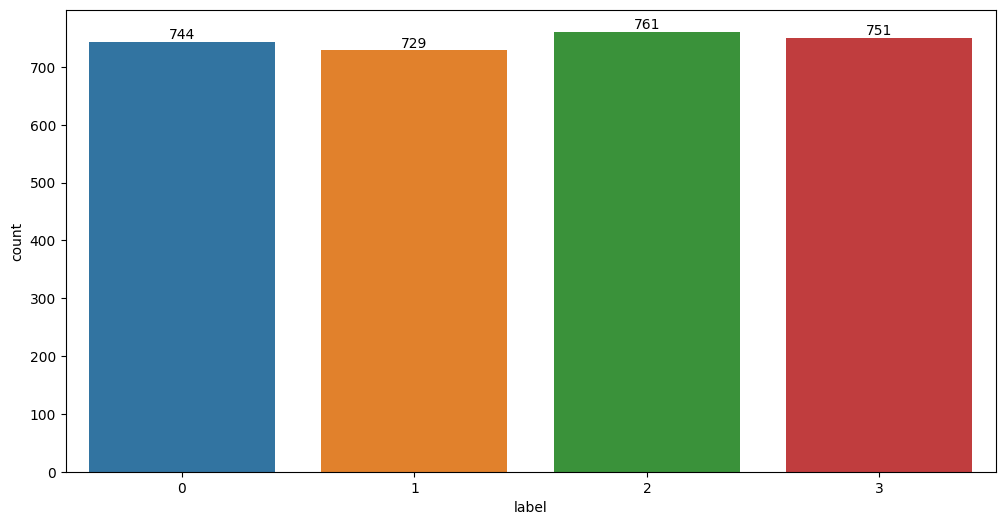

In [12]:
fig = plt.figure(figsize=(12, 6))
ax = sns.countplot(x='label', data=cosmos_validate_df)
ax.bar_label(ax.containers[0])

## Adjust & Export Datasets for Train/Validate/Test

In [13]:
# shuffle dataframe and reset index
cosmos_train_df = cosmos_train_df.sample(frac=1, random_state=1).reset_index(drop=True)

cosmos_train_df.head()

,id,context,question,answer0,answer1,answer2,answer3,label
0,3J6BHNX0U9QBFR2COTN2C3JZ3Q3KN6##30X31N5D64O55B...,It just freaked me out is all and scared the w...,"what is meant by "" cuff "" ?",Cuff is the doctor hitting you to keep you in ...,Cuff is a device that helps check blood pressu...,Cuff means checking your weight .,Cuff in this instance is the doctor helping yo...,1
1,3JMQI2OLFZ331LW2WC1F8QO9JH6NDW##3P4MQ7TPPYAB7Z...,The play is about two people who meet at a clu...,What type of play will this be ?,The play will be a sort of cute drama ( with a...,This will be a zombie play .,None of the above choices .,This will be a play in children 's theatre .,0
2,30P8I9JKOKZ0Z2PP3VHNCTI2MNK5VE##3QXNC7EIPLA6U8...,"They made me feel so much better , and they we...",What is a plausible reason for me to go to the...,I fell and hit my head on the floor and may ha...,They know that I need assistance for most thin...,None of the above choices .,They know I have trouble making up my mind .,0
3,322ZSN9Z5IY3QRH0KVYY6JO3O3C4TO##34Q075JO10SO53...,I have been having my asthma since 2001 . Exac...,What may be the reason for their attack ?,They had recently been diagnosed with asthma .,They needed to see their doctor more .,They are prone to asthma attacks .,None of the above choices .,2
4,3TUOHPJXYJBMGA94ZB5EQES0L7YXWF##3HOSI13XH23CWI...,There is not a scratch on any of the furniture...,What may be the reason for there not being any...,None of the above choices .,Because they fixed it .,Because they did n't actually have furniture .,Because they took good care of it .,3


In [14]:
cosmos_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25262 entries, 0 to 25261
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        25262 non-null  object
 1   context   25262 non-null  object
 2   question  25262 non-null  object
 3   answer0   25262 non-null  object
 4   answer1   25262 non-null  object
 5   answer2   25262 non-null  object
 6   answer3   25262 non-null  object
 7   label     25262 non-null  int32 
dtypes: int32(1), object(7)
memory usage: 1.4+ MB


### Test Split

In [15]:
# get 2,825 samples
cosmos_test = cosmos_train_df.sample(2825, random_state=1)
cosmos_test

,id,context,question,answer0,answer1,answer2,answer3,label
24637,3J9L0X0VDH0WFER6WVZ0AB6IE479W8##3IFS6Q0HJLYZ6I...,I fought back and probably did more damage tha...,Why did I abuse myself ?,To control my appetite .,To control my emotional pain .,To make look like I was attacked .,None of the above choices .,1
7177,3NZ1E5QA6ZZ6WZSCEGENJJ0NPBV5BI##33L7PJKHCHWS1N...,After four hours on the road I started playing...,Why is the narrator playing a game with licens...,The narrator is looking to take meticulous rec...,None of the above choices .,The narrator is looking to keep tabs on other ...,The narrator is looking to pass the time in th...,3
10039,3XH7ZM9YX48R7IAKX1PUNCY1N3TR9H##3WMINLGALEI4TJ...,The waitresses saw the Indian and Iranian guys...,Why did the other guests get more attention ?,None of the above choices .,They had a new car .,They had deep pockets .,They had a relationship with the waitress .,2
17916,3MDKGGG61QL2BPM7JLFDBJK9SED6TZ##324G5B4FB46NL0...,"Darling daughter , Lynny , got her exam result...",What grade must have Lynny gotten in her Engli...,She must have gotten Bs or below,She must have gotten Cs or below,None of the above choices .,She must have gotten As or below,1
1906,334ZEL5JX6DRLVFWUHWHIEAEAULSOA##3DR23U6WE6C9AO...,"So , this last Monday , I was supposed to reci...",What occured before the call ?,I kept busy thinking of Winterlion .,I called Winterlion .,None of the above choices .,I visited Winterlion .,2
...,...,...,...,...,...,...,...,...
17609,3AQN9REUTHUC79ZNNCMQH4AOFI9YD5##35GMH2SV3HW8SL...,"Or bother to , for that matter . Or so I tried...",Why is the narrator confused by the girl 's ac...,They think she is an idiot .,None of the above choices .,They think she is a boy .,They think she has germs .,2
23952,3M4KL7H8KVL125AYH2V35D1EZUF61G##3GA6AFUKOPMGVH...,"Forget the garden existed , nothing but rottin...",How does the speaker feel about this ?,The speaker did not grow much,The speaker was living there,None of the above choices .,The speaker is feels disappointed,3
14570,3UQVX1UPFSFDDF6FYHF01V1SEX702Q##3X08E93BHWGZVB...,Jump to the full entry & travel map Buneos Air...,Why is the narrator choosing to stay at Hostel...,None of the above choices .,It is the only option available last second .,The narrator feels the hostel is nice .,The narrator feels it is homy .,1
3676,3QTFNPMJC8WLYB058S2CRGVKYF9NZU##3BF51CHDTYPZ9E...,I went to the mall this weekend and my mom dra...,What will be the most likely outcome of the sh...,The clothing will not fit the writer 's style .,None of the above choices .,The writer 's mother will purchase new clothing .,The writer will have an updated wardrobe .,3


In [16]:
# remove test set samples from dataset
cosmos_train_df = cosmos_train_df.drop(cosmos_test.index)
cosmos_train_df


,id,context,question,answer0,answer1,answer2,answer3,label
1,3JMQI2OLFZ331LW2WC1F8QO9JH6NDW##3P4MQ7TPPYAB7Z...,The play is about two people who meet at a clu...,What type of play will this be ?,The play will be a sort of cute drama ( with a...,This will be a zombie play .,None of the above choices .,This will be a play in children 's theatre .,0
3,322ZSN9Z5IY3QRH0KVYY6JO3O3C4TO##34Q075JO10SO53...,I have been having my asthma since 2001 . Exac...,What may be the reason for their attack ?,They had recently been diagnosed with asthma .,They needed to see their doctor more .,They are prone to asthma attacks .,None of the above choices .,2
4,3TUOHPJXYJBMGA94ZB5EQES0L7YXWF##3HOSI13XH23CWI...,There is not a scratch on any of the furniture...,What may be the reason for there not being any...,None of the above choices .,Because they fixed it .,Because they did n't actually have furniture .,Because they took good care of it .,3
5,3S829FDFT4FN749DIG0OYQ3FFAOXD5##3FUI0JHJP0DGWY...,Resting my head on my squishy canvas Marc Jaco...,What sort of mood might the narrator be in ?,None of the above choices .,Delusional,Angry,Reflective,3
6,3W1K7D6QSDVJX2B852X30LVQKKFZBS##3D3VGR7TA3U8F0...,"All the small morning notes , and long , thoug...",Why is the the speaker feeling melancholy ?,She is preparing her wedding vows .,Remembering lost love .,She is reliving past mistakes .,None of the above choices .,1
...,...,...,...,...,...,...,...,...
25257,3X2LT8FDHYWW198WR3TMAFB7TJBW8X##3OS46CRSLIEZ5Q...,The Daily Mail had a lovely interview with Bru...,What may we read in the newspaper ?,Somebody teaching kids how to dance .,A dancer 's struggle in life .,The story of a famous person .,None of the above choices .,2
25258,3NKW03WTLM5NDO9LTZYM488ZV8ZQWV##3DR23U6WE6C9AO...,It seemed like every team book had a guy with ...,Why do so many characters featured by the narr...,The narrator is looking at old manuscripts .,The narrator is looking at The Bible .,None of the above choices .,The narrator is looking at action - laden comi...,3
25259,3WRAAIUSBJXAF87UE8XMGR710SJXAO##3EF8EXOTT2TGCK...,My goal is to try 2/5 once my bankroll reaches...,What might happen in Vegas ?,I might lose my money at the ATM machine .,I might lose my mind from too much winning .,I might lose all my clothes from a robbery .,None of the above choices .,3
25260,37SOB9Z0SSVFVTRKRAFOIPY8OMKL3O##37FMASSAYDPLU7...,I try to let my family do most of the math . W...,How would one describe the narrator 's family ?,Their family is so - so at math .,Their family is math - oriented .,Their family is not intelligent .,Their family is bad at math .,1


### Train Split

[Text(0, 0, '5632'),
 Text(0, 0, '5623'),
 Text(0, 0, '5614'),
 Text(0, 0, '5568')]

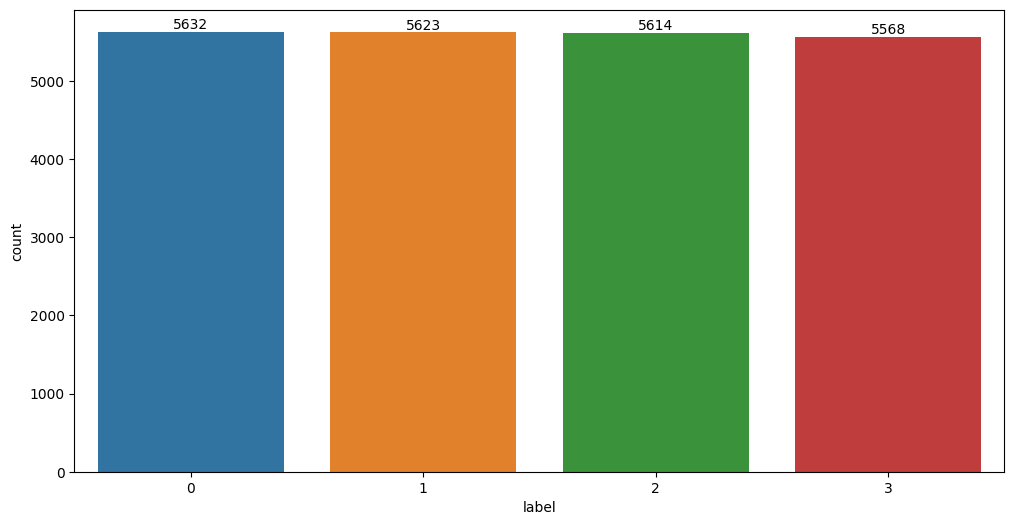

In [17]:
fig = plt.figure(figsize=(12, 6))
ax = sns.countplot(x='label', data=cosmos_train_df)
ax.bar_label(ax.containers[0])

In [18]:
# get samples for each class equal to the number of available samples for the smallest class
cosmos_train = cosmos_train_df.groupby('label', group_keys=False).apply(lambda x: x.sample(min(len(x), min(np.unique(cosmos_train_df['label'], return_counts=True)[1])), random_state=1).sample(frac=1, random_state=1))
cosmos_train

,id,context,question,answer0,answer1,answer2,answer3,label
18626,32TMVRKDGPCKS7PCHXN3FNSG8P848C##36U2A8VAG4EN8Z...,I really thought that my dream had come true ....,What is going to happen to the married couple ?,They are going to split .,None of the above choices .,They are going to renew vows .,They are going to have a kid .,0
5879,33J5JKFMK6WQMQ7XJFNKZBX2YGB3QB##3JW0YLFXRUEVJ5...,"No he had not . The ' he ' in question , was a...",What may I be currently doing right now ?,Taking a vacation,Planning a promotion,Planning a wedding,None of the above choices .,0
20286,3RSBJ6YZEE4XBF9H8V8I3DF7E03OF3##3WMINLGALEI4TJ...,"Funny , how past mistakes can haunt you , and ...",What does the narrator think of people ?,They will always harm one another .,Being with them is a blissful euphoria .,They are a past mistake .,They hold people dear to them .,0
301,33P2GD6NRNQJ5VG1LVSP7JM3IBGKHE##3OUYGIZWR8WCR6...,Well I got my end of the summer party like I w...,Why do you supposed the author thinks that sak...,Most likely they got very drunk very fast from...,Sake is beastly when you drink it at summer pa...,None of the above choices .,"Because Tony was gone , meaning the beast ( th...",0
333,3P0I4CQYV0LZM1VCYKII71177NAOWK##39ASUFLU60MVMU...,At one time I had two cats who would hiss and ...,Why is the narrator failing to get good sleep ...,The pets are fighting .,The kids are yelling .,The husband is snoring .,The dogs are fighting .,0
...,...,...,...,...,...,...,...,...
8593,30Y6N4AHYPUOGJOUPJIWHATJLUGRD6##3PQMUDRV7S4VHF...,Today I was needing a break from being Mommy ....,why does she feel she needs a break ?,she wants her husband to take care of the chil...,she wants a permanent break from her children,she does not care about her children,None of the above choices .,3
15725,3BO3NEOQM0FDPDIZFMXLDHKMDA2AIF##35GCEFQ6I6M2M2...,Last night was bad . First I woke up with cont...,What would best describe having symptoms of co...,Period,Sprained muscle,None of the above choices .,Pregnancy,3
1311,3GVPRXWRPHSV6BK18JL13QIWCGOI7G##3Q5C1WP23NZ85L...,Two things I really love in the world are - ha...,What may be the reason for their love of cloth...,None of the above choices .,They used to make their own clothes .,They keep up with fashion trends .,They have been influenced by their parents .,3
4874,3538U0YQ1H88PQGVPXOQFAHWIUV3FG##3DBQWDE4Y9DQEH...,"i do n't know how long exactly , but the fact ...",What part of my body may be sick ?,my heart,my head,my leg,my vagina,3


### Double-Check Distribution
Our training set distribution is perfectly balanced while our validation and test sets are representative of the original dataset's distribution.

Text(0.5, 1.0, 'Train Set Label Distribution')

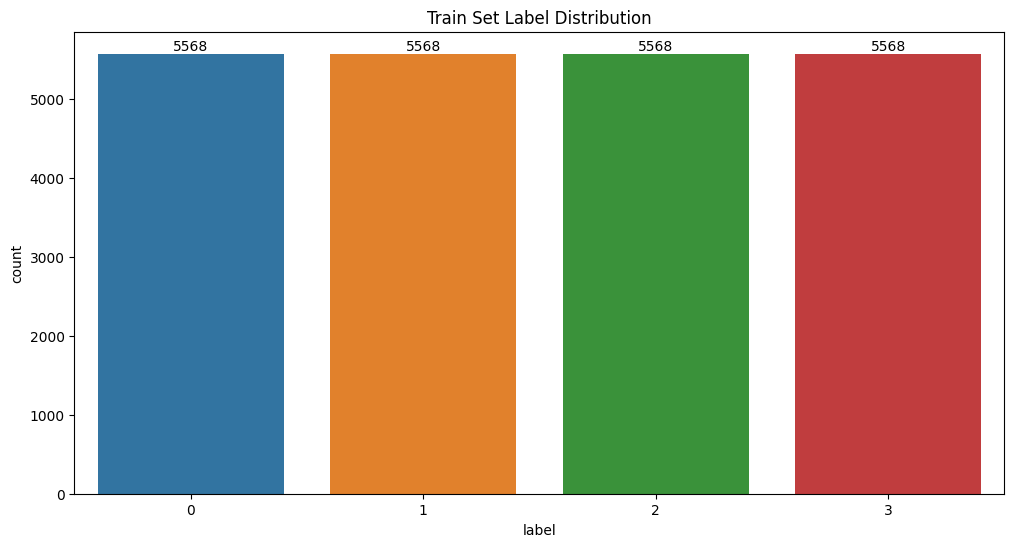

In [19]:
fig = plt.figure(figsize=(12, 6))
ax = sns.countplot(x='label', data=cosmos_train)
ax.bar_label(ax.containers[0])
plt.title("Train Set Label Distribution")

2985


Text(0.5, 1.0, 'Validation Set Label Distribution')

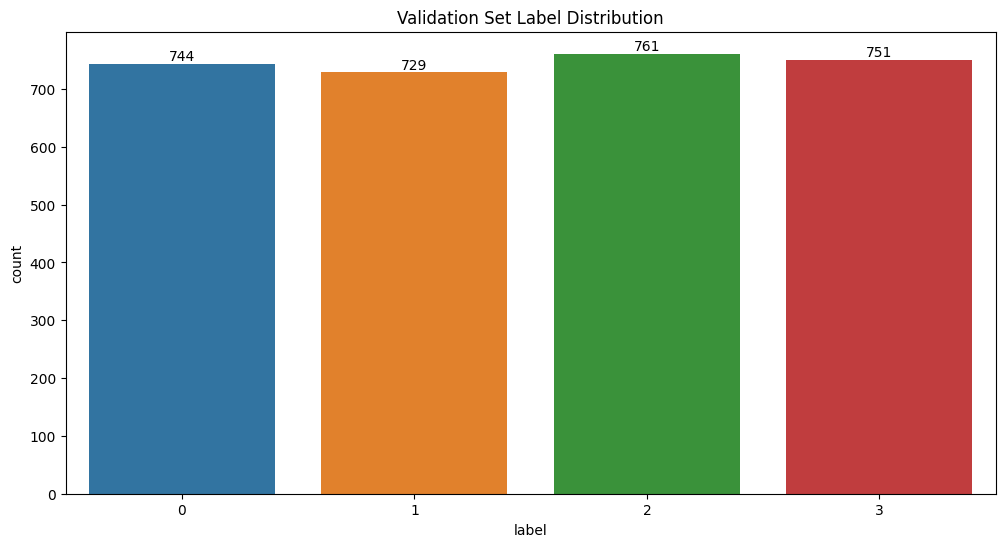

In [20]:
print(len(cosmos_validate_df))
fig = plt.figure(figsize=(12, 6))
ax = sns.countplot(x='label', data=cosmos_validate_df)
ax.bar_label(ax.containers[0])
plt.title("Validation Set Label Distribution")

2825


Text(0.5, 1.0, 'Test Set Label Distribution')

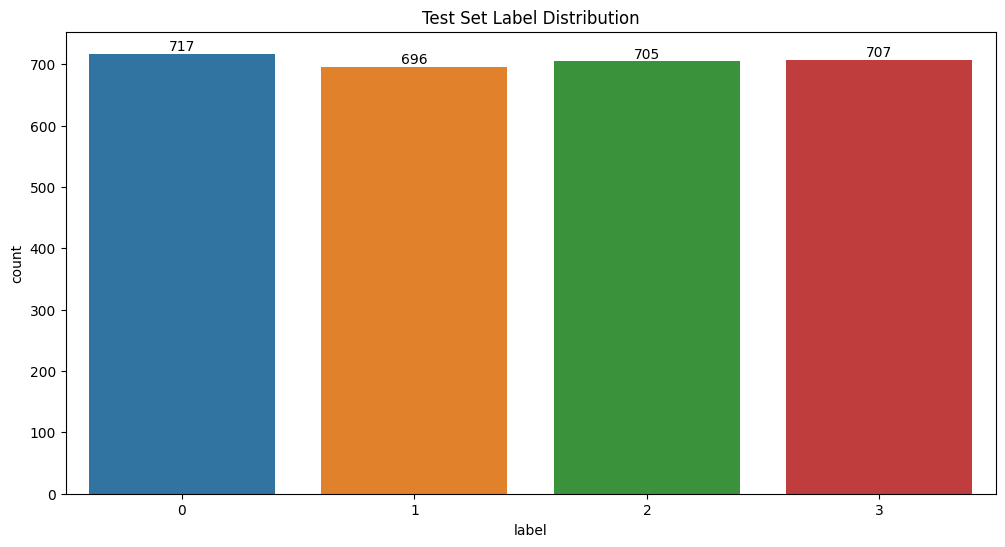

In [21]:
print(len(cosmos_test))
fig = plt.figure(figsize=(12, 6))
ax = sns.countplot(x='label', data=cosmos_test)
ax.bar_label(ax.containers[0])
plt.title("Test Set Label Distribution")

## Export Fine-Grain Datasets

In [22]:
# reconstitute the updated datafames into a DatasetDict object
fine_train_dataset = Dataset.from_pandas(cosmos_train, preserve_index=False)
fine_validate_dataset = Dataset.from_pandas(cosmos_validate_df, preserve_index=False)
fine_test_dataset = Dataset.from_pandas(cosmos_test, preserve_index=False)
cosmos_datasets = datasets.DatasetDict({"train":fine_train_dataset, 
                                          "validation":fine_validate_dataset, 
                                          "test":fine_test_dataset})

In [23]:
cosmos_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'context', 'question', 'answer0', 'answer1', 'answer2', 'answer3', 'label'],
        num_rows: 22272
    })
    validation: Dataset({
        features: ['id', 'context', 'question', 'answer0', 'answer1', 'answer2', 'answer3', 'label'],
        num_rows: 2985
    })
    test: Dataset({
        features: ['id', 'context', 'question', 'answer0', 'answer1', 'answer2', 'answer3', 'label'],
        num_rows: 2825
    })
})

In [24]:
cosmos_datasets.save_to_disk("data/inter_CosmosQA/itesd_cosmosqa_balanced.hf")

Saving the dataset (0/1 shards):   0%|          | 0/22272 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2985 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2825 [00:00<?, ? examples/s]